# Fake News Detection Using Bidirectional LSTM
## Reynara Ezra Pratama

## Introduction

## Learning Objective

1. Mengetahui konsep dan cara kerja dari Bidirectional LSTM (BiLSTM)
2. Implementasi BiLSTM pada permasalahan nyata

## LSTM vs BiLSTM

## Case Example Using BiLSTM

### Background

### Business Understanding

### Data Understanding

Terdapat dua buah dataset yang kita gunakan yaitu `Fake.csv` dan `True.csv`. Dataset `Fake.csv` berisi kumpulan berita yang terindikasi *fake* atau hoax sementara dataset `True.csv` berisi kumpulan berita yang faktanya adalah benar.

Terdapat 4 buah kolom pada kedua dataset yaitu `title`, `text`, `subject`, `date`.
1. `title` : Judul berita 
2. `text` : Isi konten dari berita yang ada
3. `subject` : Subjek dari artikel berita
4. `date` : Tanggal artikel diterbitkan

### Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
#from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
import nltk
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

import warnings 
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Loading Dataset

**Load Data From Github**

In [2]:
url_fake = 'https://raw.githubusercontent.com/ReynaraEzra/Fake-News-Detection/main/data_input/Fake.csv'
url_true = 'https://raw.githubusercontent.com/ReynaraEzra/Fake-News-Detection/main/data_input/True.csv'
fake = pd.read_csv(url_fake)
true = pd.read_csv(url_true)

**Load Data From Local File**

In [3]:
# fake = pd.read_csv('data_input/Fake.csv')
# true = pd.read_csv('data_input/True.csv')

### Checking Dataset

In [4]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## Text Preprocessing

In [6]:
fake['label'] = 1
true['label'] = 0
data = pd.concat([fake, true])
data = data.reset_index(drop=True)
data.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


Terlihat bahwa terdapat 44898 artikel yang ada pada `data` dengan total 5 buah kolom yang terdiri atas 1 kolom bertipe *integer* dan 4 kolom bertipe *object*.

In [8]:
def make_count_plot(data, xlabel, size_x, size_y):
    plt.figure(figsize=(size_x, size_y))
    p = sns.countplot(data)
    plt.xlabel(xlabel, fontsize=12)
    p.set_xticklabels(['True News', 'Fake News'])
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Number of Article Based on {xlabel}', fontsize=15)
    plt.show()

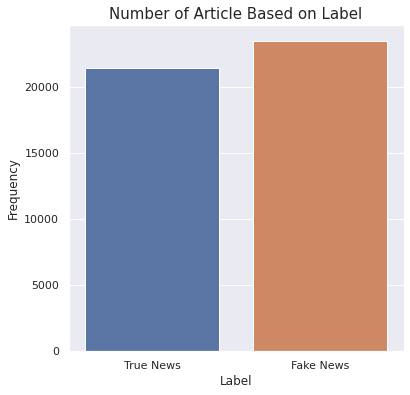

Jumlah Artikel yang dikategorikan Fake News : 23481
Jumlah Artikel yang dikategorikan True News : 21417


In [9]:
make_count_plot(data['label'], 'Label', 6, 6)
print(f"Jumlah Artikel yang dikategorikan Fake News : {data[data['label']==1].shape[0]}")
print(f"Jumlah Artikel yang dikategorikan True News : {data[data['label']==0].shape[0]}")

Jumlah artikel yang dikategorikan ke dalam *Fake News* dan *True News* sudah seimbang, maka tidak perlu dilakukan proses *downsampling* atau *upsampling* pada data.

In [10]:
df = data.drop(['subject', 'date'], axis=1)

In [11]:
df.head()

,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,1


In [12]:
df['content'] = df['title'] + ' ' + df['text']

In [13]:
df.head()

,title,text,label,content
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,1,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,1,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",1,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",1,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,1,Pope Francis Just Called Out Donald Trump Dur...


In [14]:
df = df.drop(['title', 'text'], axis=1)[['content', 'label']]

In [15]:
df.head()

,content,label
0,Donald Trump Sends Out Embarrassing New Year’...,1
1,Drunk Bragging Trump Staffer Started Russian ...,1
2,Sheriff David Clarke Becomes An Internet Joke...,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,1
4,Pope Francis Just Called Out Donald Trump Dur...,1


In [16]:
df.iloc[0,0]

' Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this 

In [17]:
test = df.iloc[0,0]

In [18]:
stop_en = stopwords.words('english')
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [19]:
text_process = re.sub('[^a-zA-Z]', ' ', test).lower().split()

In [20]:
text_process

['donald',
 'trump',
 'sends',
 'out',
 'embarrassing',
 'new',
 'year',
 's',
 'eve',
 'message',
 'this',
 'is',
 'disturbing',
 'donald',
 'trump',
 'just',
 'couldn',
 't',
 'wish',
 'all',
 'americans',
 'a',
 'happy',
 'new',
 'year',
 'and',
 'leave',
 'it',
 'at',
 'that',
 'instead',
 'he',
 'had',
 'to',
 'give',
 'a',
 'shout',
 'out',
 'to',
 'his',
 'enemies',
 'haters',
 'and',
 'the',
 'very',
 'dishonest',
 'fake',
 'news',
 'media',
 'the',
 'former',
 'reality',
 'show',
 'star',
 'had',
 'just',
 'one',
 'job',
 'to',
 'do',
 'and',
 'he',
 'couldn',
 't',
 'do',
 'it',
 'as',
 'our',
 'country',
 'rapidly',
 'grows',
 'stronger',
 'and',
 'smarter',
 'i',
 'want',
 'to',
 'wish',
 'all',
 'of',
 'my',
 'friends',
 'supporters',
 'enemies',
 'haters',
 'and',
 'even',
 'the',
 'very',
 'dishonest',
 'fake',
 'news',
 'media',
 'a',
 'happy',
 'and',
 'healthy',
 'new',
 'year',
 'president',
 'angry',
 'pants',
 'tweeted',
 'will',
 'be',
 'a',
 'great',
 'year',
 'f

In [21]:
len(text_process)

497

In [22]:
text_process = [word for word in text_process if not word in stop_en]

In [23]:
text_process

['donald',
 'trump',
 'sends',
 'embarrassing',
 'new',
 'year',
 'eve',
 'message',
 'disturbing',
 'donald',
 'trump',
 'wish',
 'americans',
 'happy',
 'new',
 'year',
 'leave',
 'instead',
 'give',
 'shout',
 'enemies',
 'haters',
 'dishonest',
 'fake',
 'news',
 'media',
 'former',
 'reality',
 'show',
 'star',
 'one',
 'job',
 'country',
 'rapidly',
 'grows',
 'stronger',
 'smarter',
 'want',
 'wish',
 'friends',
 'supporters',
 'enemies',
 'haters',
 'even',
 'dishonest',
 'fake',
 'news',
 'media',
 'happy',
 'healthy',
 'new',
 'year',
 'president',
 'angry',
 'pants',
 'tweeted',
 'great',
 'year',
 'america',
 'country',
 'rapidly',
 'grows',
 'stronger',
 'smarter',
 'want',
 'wish',
 'friends',
 'supporters',
 'enemies',
 'haters',
 'even',
 'dishonest',
 'fake',
 'news',
 'media',
 'happy',
 'healthy',
 'new',
 'year',
 'great',
 'year',
 'america',
 'donald',
 'j',
 'trump',
 'realdonaldtrump',
 'december',
 'trump',
 'tweet',
 'went',
 'welll',
 'expect',
 'kind',
 'pre

In [24]:
len(text_process)

275

In [25]:
text_process = [lemmatizer.lemmatize(word) for word in text_process]

In [26]:
text_process

['donald',
 'trump',
 'sends',
 'embarrassing',
 'new',
 'year',
 'eve',
 'message',
 'disturbing',
 'donald',
 'trump',
 'wish',
 'american',
 'happy',
 'new',
 'year',
 'leave',
 'instead',
 'give',
 'shout',
 'enemy',
 'hater',
 'dishonest',
 'fake',
 'news',
 'medium',
 'former',
 'reality',
 'show',
 'star',
 'one',
 'job',
 'country',
 'rapidly',
 'grows',
 'stronger',
 'smarter',
 'want',
 'wish',
 'friend',
 'supporter',
 'enemy',
 'hater',
 'even',
 'dishonest',
 'fake',
 'news',
 'medium',
 'happy',
 'healthy',
 'new',
 'year',
 'president',
 'angry',
 'pant',
 'tweeted',
 'great',
 'year',
 'america',
 'country',
 'rapidly',
 'grows',
 'stronger',
 'smarter',
 'want',
 'wish',
 'friend',
 'supporter',
 'enemy',
 'hater',
 'even',
 'dishonest',
 'fake',
 'news',
 'medium',
 'happy',
 'healthy',
 'new',
 'year',
 'great',
 'year',
 'america',
 'donald',
 'j',
 'trump',
 'realdonaldtrump',
 'december',
 'trump',
 'tweet',
 'went',
 'welll',
 'expect',
 'kind',
 'president',
 's

In [27]:
len(text_process)

275

In [28]:
combined = ''
for text in text_process:
    combined = combined + text + ' '
combined

'donald trump sends embarrassing new year eve message disturbing donald trump wish american happy new year leave instead give shout enemy hater dishonest fake news medium former reality show star one job country rapidly grows stronger smarter want wish friend supporter enemy hater even dishonest fake news medium happy healthy new year president angry pant tweeted great year america country rapidly grows stronger smarter want wish friend supporter enemy hater even dishonest fake news medium happy healthy new year great year america donald j trump realdonaldtrump december trump tweet went welll expect kind president sends new year greeting like despicable petty infantile gibberish trump lack decency even allow rise gutter long enough wish american citizen happy new year bishop talbert swan talbertswan december one like calvin calvinstowell december impeachment would make great year america also accept regaining control congress miranda yaver mirandayaver december hear talk include many p

In [31]:
def text_preprocessing(texts):
    text_list = []
    for i in range(len(texts)):
        text_process = re.sub('[^a-zA-Z]', ' ', texts[i]).lower().split()
        text_process = [word for word in text_process if not word in stop_en]
        text_process = [lemmatizer.lemmatize(word) for word in text_process]
        combined = ''
        for text in text_process:
            combined = combined + text + ' '
        text_list.append(combined)
    return text_list

In [32]:
df = df.sample(frac=1).reset_index(drop=True)

In [33]:
news = df['content'].copy()
target = df['label'].copy()

In [34]:
news = text_preprocessing(news)

In [35]:
target = target.values

In [36]:
X_train, X_test, y_train, y_test = train_test_split(news, target, test_size=0.2, random_state=0)

In [37]:
tokenizer = Tokenizer(num_words=20000, oov_token='-')
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_test = tokenizer.texts_to_sequences(X_test)

pad_train = pad_sequences(sequence_train)
pad_test = pad_sequences(sequence_test)

In [38]:
reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.15,
    patience=5,
    min_lr=2.e-5
)

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

In [56]:
model = tf.keras.models.Sequential([
   tf.keras.layers.Embedding(input_dim=20000, output_dim=64),
   tf.keras.layers.Bidirectional(
       tf.keras.layers.LSTM(64, return_sequences=True)
       ),
   tf.keras.layers.Dropout(0.2),
   tf.keras.layers.LSTM(32),
  #  tf.keras.layers.Bidirectional(
  #      tf.keras.layers.LSTM(64)
  #      ),
   tf.keras.layers.Dense(16, activation='relu'),
   tf.keras.layers.Dropout(0.25),
   tf.keras.layers.Dense(8, activation='relu'),
   tf.keras.layers.Dropout(0.5),
   tf.keras.layers.Dense(1, activation='sigmoid')
])

In [57]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 64)          1280000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_12 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 8)                

In [59]:
model.compile(
    optimizer= 'Adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [60]:
history = model.fit(
    pad_train,
    y_train,
    epochs = 10,
    batch_size = 64,
    #callbacks = [reduce_LR, stop_early],
    validation_data = (pad_test, y_test),
    verbose = 1
)

Epoch 1/10
350/562 [=================>............] - ETA: 4:48 - loss: 0.2593 - accuracy: 0.8915

KeyboardInterrupt: ignored

In [ ]:
model.save('model.h5')